In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using MKLSparse
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using Plots
using ProgressMeter
using Random
using DifferentialEquations: DP5, Tsit5, BS3
ProgressMeter.ijulia_behavior(:clear)

┌ Info: Precompiling QuantumOptimalControl [e91afccf-c93e-44fd-aa4c-3d3ef13645c0]
└ @ Base loading.jl:1423


false

In [2]:
Random.seed!(1)

TaskLocalRNG()

In [3]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [4]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [5]:
n_atoms = 4
bsys = tensor([bs for i in 1:n_atoms]...);

In [6]:
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]]);

In [7]:
H = Hamiltonian(H0)
H += 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H += -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [8]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)

trans = StateTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [39]:
n_neurons = 4
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 2))
θ = initial_params(ann)  

n_params = length(θ)
Random.seed!(10)
θ = 2.0*rand(n_params).-1.0

t0, t1 = 0.0, 1.0

coeffs(params) = t->let vals = ann([t], params)
                        [sigmoid(vals[1]), vals[2]]
                    end    

dr = ParametricDrive(Vector{Float64}(θ), coeffs, (t0, t1))
cost = CostFunction((x, y) -> x'*y,
                     p->2e-10 *(ann([t0], p)[1]^2+ ann([t1], p)[1]^2))

CostFunction(var"#61#63"(), var"#62#64"())

In [40]:
prob = QOCProblem(H, dr, trans, cost);

In [41]:
prob.cost.constraints = p->2e-2 *(ann([t0], p)[1]^2+ ann([t1], p)[1]^2)
sol = QuantumOptimalControl.optimize(prob, ADAM(0.008), alg=Tsit5(), reltol=1e-6, abstol=1e-6, n_iter=3000)

Progress: 100%|█████████████████████████████████████████| Time: 0:36:31
  cost:  0.9968070636938497


Solution{Float64}([1.8540301719152679, 2.2989578958250463, 3.610798208267443, 0.9942104856930702, -1.6543896866928438, -1.0001542949997764, -0.4628271949010369, -0.7953833506239257, 2.8770490056054037, 0.7014752468806532  …  -1.3151763645665182, -10.215284548718971, 1.4785707756141337, 1.6070330488945936, 0.009398203349326974, -3.1073995408697233, 3.278056092051318, -1.7740012865289347, 0.30555000430421886, 2.3378390578493464], [-0.2632991470227176, 0.09418011323962816, 0.373642799754823, 0.41262043681806587, 0.3677996333774546, 0.3498054857372208, 0.3607953363444558, 0.39380607036116005, 0.4487235455848009, 0.5258476269905561  …  0.9967958682247339, 0.9967971222984503, 0.9967983730206886, 0.9967996222555848, 0.9968008680043878, 0.9968021124474171, 0.996803353198698, 0.9968045929132994, 0.9968058286266874, 0.9968070636938497])

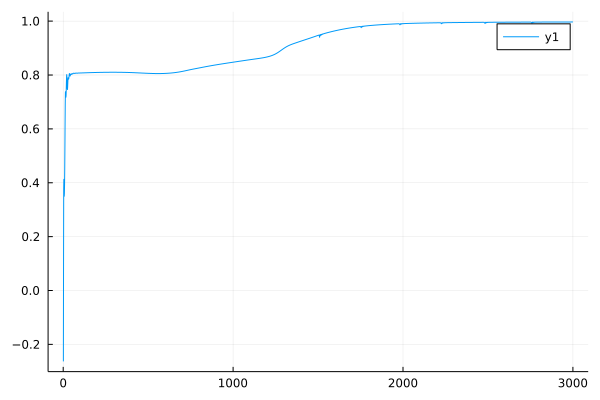

In [42]:
plot(sol.trace)

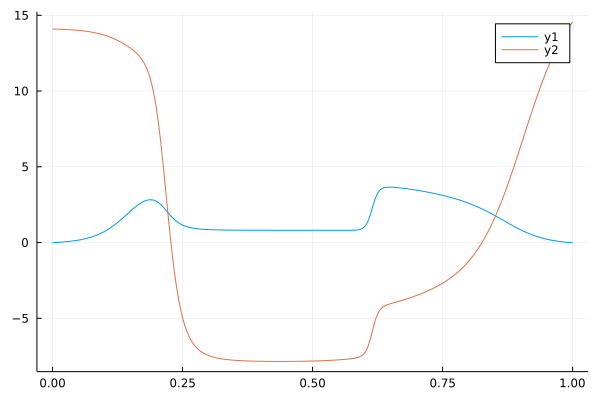

In [43]:
Ω(t) = let vals = ann([t], prob.drive.params)
        abs(vals[1])
       end
Δ(t) = let vals = ann([t], prob.drive.params)
        vals[2]
       end

ts = t0:0.001:t1
f = plot(ts, Ω.(ts))
plot!(f, ts, Δ.(ts))